# Interpret LightGBM Classifier with SHAP: Spaceship Titanic Dataset

## Introduction

This notebook demonstrates how to utilize SHAP (SHapley Additive exPlanations) to interpret complex gradient-boosted models, specifically LightGBM. The purpose is to make the results of these models more interpretable to both yourself and stakeholders. SHAP provides a unified framework to explain the output of any machine learning model, helping you understand the contribution of each feature to the predictions.

## Table of Contents

1. [Data Preparation](#data-preparation)
   - [Import Data and Modules](#import-data-and-modules)
   - [Feature Engineering](#feature-engineering)
   - [Data Cleaning](#data-cleaning)
2. [Modeling](#modeling)
   - [Data Preprocessing for Modeling](#data-preprocessing-for-modeling)
   - [Model Training](#model-training)
   - [Model Evaluation](#model-evaluation)
   - [Submit Predictions](#submit-predictions)
3. [Interpretability](#interpretability)
   - [SHAP Analysis](#shap-analysis)

# 1) Data Preparation -------------------------
<a id="data-preparation"></a>

## Data Description

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

> * **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.<br>
> * **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.<br>
> * **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.<br>
> * **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.<br>
> * **Destination** - The planet the passenger will be debarking to.<br>
> * **Age** - The age of the passenger.<br>
> * **VIP** - Whether the passenger has paid for special VIP service during the voyage.<br>
> * **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.<br>
> * **Name** - The first and last names of the passenger.<br>
> * **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.<br>

## Import Data and Modules
<a id="import-data-and-modules"></a>

In [1]:
# Base modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Text modules
from nltk.corpus import names
from nltk.classify import NaiveBayesClassifier
import nltk

# Modeling and evaluation
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import shap
import os

In [2]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
train['set'] = "train"
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
test['set'] = "test"
df = pd.concat([train, test], ignore_index=False)

In [3]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,set
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,train
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,train
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,train
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,train
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,train


## Feature Engineering
<a id="feature-engineering"></a>

### 1. Create Group vs solo Feature

In [4]:
df['PassengerGroup'] = df['PassengerId'].str[:4]

group_counts = df['PassengerGroup'].value_counts().sort_index()

df['GroupSize'] = df.groupby('PassengerGroup')['PassengerId'].transform('count')

In [5]:
df['solo_traveler'] = df['GroupSize'].apply(lambda x: True if x > 1 else False)

In [6]:
df['GroupSize'].value_counts()

GroupSize
1    7145
2    2590
3    1506
4     616
5     380
7     329
6     252
8     152
Name: count, dtype: int64

### 2. Feature Engineer Cabin Data

#### 2.1) Break Out Cabin Into Deck / Number / Side

In [7]:
def split_cabin(cabin):
    if pd.isna(cabin):
        return pd.Series([None, None, None])
    parts = cabin.split('/')
    deck = parts[0]
    number = parts[1]
    side = 'Port' if parts[2] == 'P' else 'Starboard'
    return pd.Series([deck, number, side])

df[['cabin_deck', 'cabin_number', 'cabin_side']] = df['Cabin'].apply(split_cabin)

#### 2.2) Bin Cabin Number

In [8]:
# Convert the cabin_number column to numeric
df['cabin_number'] = pd.to_numeric(df['cabin_number'], errors='coerce')

# Convert the maximum value to an integer
max_cabin_number = int(df['cabin_number'].max())

# Bin the cabin_number column into groups of 300 starting at 0
bins = range(0, max_cabin_number + 50, 50)
labels = range(1, len(bins))  # Numeric labels starting from 1
df['cabin_region'] = pd.cut(df['cabin_number'], bins=bins, labels=labels, right=False)

#### 2.3) Group Decks into Categories

In [9]:
# Define the new combined deck categories based on the provided bins
def combined_deck_category(deck):
    if deck == 'A':
        return 'top_deck'
    elif deck in ['B', 'C']:
        return 'upper_deck'
    elif deck in ['D', 'E']:
        return 'mid_deck'
    elif deck in ['F', 'G']:
        return 'lower_deck'
    elif deck == 'T':
        return 'bottom_deck'
    else:
        return np.nan

# Apply the function to create the new combined deck categories
df['cabin_deck'] = df['cabin_deck'].apply(combined_deck_category)

In [10]:
df[['cabin_deck', 'cabin_side', 'cabin_region']].head()

,cabin_deck,cabin_side,cabin_region
0,upper_deck,Port,1
1,lower_deck,Starboard,1
2,top_deck,Starboard,1
3,top_deck,Starboard,1
4,lower_deck,Starboard,1


#### 2.4) Create Relative Risk Feature for Cabin Location

In [11]:
# Ensure columns are strings for concatenation
df['cabin_deck'] = df['cabin_deck'].astype(str)
df['cabin_region'] = df['cabin_region'].astype(str)

# Create the new feature by combining 'cabin_deck' and 'cabin_region'
df['cabin_location'] = df['cabin_deck'] + "_" + df['cabin_region']

# Calculate the average share of 'Transported' for the combined feature
average_share_cabin_location = df[df['set'] == 'train'].groupby('cabin_location')['Transported'].mean()

# Handle missing values by calculating the average share for non-missing parts
average_share_deck = df[df['set'] == 'train'].groupby('cabin_deck')['Transported'].mean()
average_share_region = df[df['set'] == 'train'].groupby('cabin_region')['Transported'].mean()

# Drop columns to avoid conflicts before merging
df = df.drop(columns=['average_risk_cabin_location', 'average_share_deck', 'average_share_region'], errors='ignore')

# Merge the calculated average share back to the dataframe
df = df.merge(average_share_cabin_location.rename('average_risk_cabin_location'), on='cabin_location', how='left')
df = df.merge(average_share_deck.rename('average_share_deck'), on='cabin_deck', how='left')
df = df.merge(average_share_region.rename('average_share_region'), on='cabin_region', how='left')

# Fill missing values in the combined feature with the average of the non-missing parts
df['average_risk_cabin_location'] = df['average_risk_cabin_location'].combine_first((df['average_share_deck'] + df['average_share_region']) / 2)

# Convert average_risk_cabin_location to float
df['average_risk_cabin_location'] = df['average_risk_cabin_location'].astype(float)

# Ensure no division by zero errors
df['average_risk_cabin_location'] = df['average_risk_cabin_location'].clip(0.0001, 0.9999)

# Calculate the log of relative risk for each person
df['cabin_location_relative_risk'] = np.log(df['average_risk_cabin_location'] / (1 - df['average_risk_cabin_location']))

In [12]:
# Display the first few rows of the updated dataframe
df[['PassengerId', 'cabin_location', 'average_risk_cabin_location', 'cabin_location_relative_risk']].head()

,PassengerId,cabin_location,average_risk_cabin_location,cabin_location_relative_risk
0,0001_01,upper_deck_1,0.680365,0.755451
1,0002_01,lower_deck_1,0.487654,-0.049393
2,0003_01,top_deck_1,0.486726,-0.053110
3,0003_02,top_deck_1,0.486726,-0.053110
4,0004_01,lower_deck_1,0.487654,-0.049393


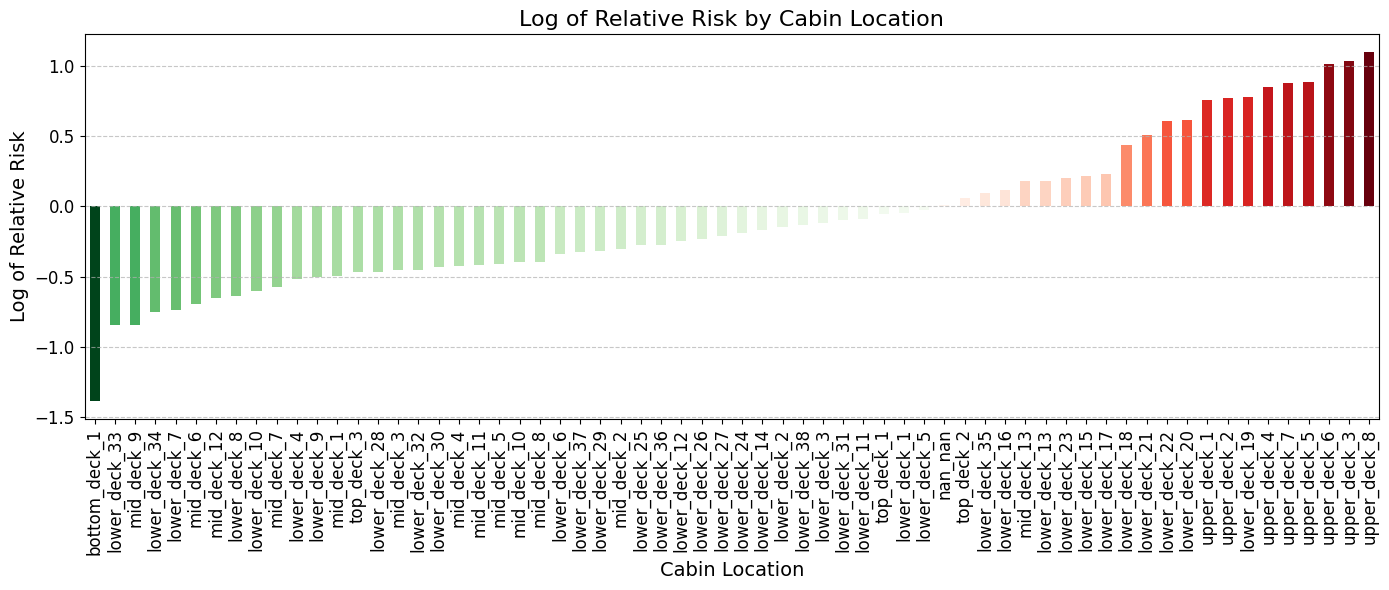

In [13]:
# Group by cabin_location and calculate the mean of log_relative_risk
log_risk_by_cabin_location = df.groupby('cabin_location')['cabin_location_relative_risk'].mean().sort_values()

# Define the colormap function
def get_color(val):
    if val > 0:
        return plt.cm.Reds(val / max(log_risk_by_cabin_location))
    else:
        return plt.cm.Greens(abs(val) / abs(min(log_risk_by_cabin_location)))

# Apply the colormap
colors = log_risk_by_cabin_location.apply(get_color)

# Plotting
plt.figure(figsize=(14, 6))
log_risk_by_cabin_location.plot(kind='bar', color=colors)
plt.title('Log of Relative Risk by Cabin Location', fontsize=16)
plt.xlabel('Cabin Location', fontsize=14)
plt.ylabel('Log of Relative Risk', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

### 4. Create Age Feature

#### 4.1) Bin Age

In [14]:
def age_group(age):
    if pd.isna(age):
        return None
    elif age < 10:
        return 'Kid'
    elif age < 18:
        return 'Teen'
    else:
        return 'Adult'

df['Age'] = df['Age'].apply(age_group)

#### 4.2) Deal with Missing Age

In [15]:
# Calculate total spend
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df['TotalSpend'] = df[spending_columns].sum(axis=1)

# Impute missing ages as 'Kid' where TotalSpend is 0, otherwise impute as 'Adult'
df.loc[df['Age'].isnull() & (df['TotalSpend'] == 0), 'Age'] = 'Kid'
df.loc[df['Age'].isnull(), 'Age'] = 'Adult'

#### 4.3) Deal with Missing CryoSleep

In [16]:
# Impute CryoSleep as True where TotalSpend is 0
df.loc[df['CryoSleep'].isnull() & (df['TotalSpend'] == 0), 'CryoSleep'] = True

# Kids: Randomly assign based
kid_indices = df[(df['Age'] == 'Kid') & df['CryoSleep'].isnull()].index
df.loc[kid_indices, 'CryoSleep'] = np.random.choice([True, False], size=len(kid_indices), p=[0.5, 0.5])

# Teens: Randomly assign
teen_indices = df[(df['Age'] == 'Teen') & df['CryoSleep'].isnull()].index
df.loc[teen_indices, 'CryoSleep'] = np.random.choice([True, False], size=len(teen_indices), p=[0.5, 0.5])

# Adults: Assign False
df.loc[(df['Age'] == 'Adult') & df['CryoSleep'].isnull(), 'CryoSleep'] = False

#### 4.4) Merge Age and CryoSleep

In [17]:
# Convert CryoSleep to string
df['CryoSleep'] = df['CryoSleep'].astype(str)

# Create merged feature
df['Age+CryoSleep'] = df['Age'] + '_' + df['CryoSleep']

In [18]:
df['Age+CryoSleep'].value_counts()

Age+CryoSleep
Adult_False    7087
Adult_True     3490
Teen_False      668
Kid_True        620
Teen_True       616
Kid_False       489
Name: count, dtype: int64

#### 5) Impute Spend

In [19]:
# Impute spending columns
for column in spending_columns:
    # Impute with 0 if in CryoSleep
    df.loc[df['CryoSleep'] == 'True', column] = df.loc[df['CryoSleep'] == 'True', column].fillna(0)
    
    # Impute with median spend based on AgeGroup for remaining missing values
    df[column] = df.groupby('Age')[column].transform(lambda x: x.fillna(x.median()))

## Data Cleaning
<a id="data-cleaning"></a>

### 1. Drop Columns

In [20]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'set', 'PassengerGroup', 'GroupSize',
       'solo_traveler', 'cabin_deck', 'cabin_number', 'cabin_side',
       'cabin_region', 'cabin_location', 'average_risk_cabin_location',
       'average_share_deck', 'average_share_region',
       'cabin_location_relative_risk', 'TotalSpend', 'Age+CryoSleep'],
      dtype='object')

In [21]:
df =  df[[
        'Age+CryoSleep',
        'cabin_location_relative_risk',
        'HomePlanet',
        'VIP',
        'Destination',
        'RoomService',
        'FoodCourt', 
        'ShoppingMall', 
        'Spa', 
        'VRDeck', 
        'solo_traveler',
        'GroupSize',
        'cabin_side',
        'cabin_deck',
        'cabin_region',
        'Transported', 
        'set', 
        'PassengerId']]

In [22]:
df.head()

,Age+CryoSleep,cabin_location_relative_risk,HomePlanet,VIP,Destination,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,solo_traveler,GroupSize,cabin_side,cabin_deck,cabin_region,Transported,set,PassengerId
0,Adult_False,0.755451,Europa,False,TRAPPIST-1e,0.0,0.0,0.0,0.0,0.0,False,1,Port,upper_deck,1,False,train,0001_01
1,Adult_False,-0.049393,Earth,False,TRAPPIST-1e,109.0,9.0,25.0,549.0,44.0,False,1,Starboard,lower_deck,1,True,train,0002_01
2,Adult_False,-0.053110,Europa,True,TRAPPIST-1e,43.0,3576.0,0.0,6715.0,49.0,True,2,Starboard,top_deck,1,False,train,0003_01
3,Adult_False,-0.053110,Europa,False,TRAPPIST-1e,0.0,1283.0,371.0,3329.0,193.0,True,2,Starboard,top_deck,1,False,train,0003_02
4,Teen_False,-0.049393,Earth,False,TRAPPIST-1e,303.0,70.0,151.0,565.0,2.0,False,1,Starboard,lower_deck,1,True,train,0004_01


# 2) Modeling -------------------------
<a id="modeling"></a>

## Data Preprocessing for Modeling
<a id="data-preprocessing-for-modeling"></a>

### 1. Encode Categorical Features

In [23]:
label_encoders = {}
categorical_features = ['HomePlanet',
                        'Age+CryoSleep',
                        'solo_traveler',
                        'Destination', 
                        'VIP', 
                        'cabin_deck',
                        'cabin_region',
                        'cabin_side']

for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Ensure all columns are the correct data type
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [24]:
df.head()

,Age+CryoSleep,cabin_location_relative_risk,HomePlanet,VIP,Destination,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,solo_traveler,GroupSize,cabin_side,cabin_deck,cabin_region,Transported,set,PassengerId
0,0,0.755451,1,0,2,0.0,0.0,0.0,0.0,0.0,0,1,1,5,0,False,train,0001_01
1,0,-0.049393,0,0,2,109.0,9.0,25.0,549.0,44.0,0,1,2,1,0,True,train,0002_01
2,0,-0.053110,1,1,2,43.0,3576.0,0.0,6715.0,49.0,1,2,2,4,0,False,train,0003_01
3,0,-0.053110,1,0,2,0.0,1283.0,371.0,3329.0,193.0,1,2,2,4,0,False,train,0003_02
4,4,-0.049393,0,0,2,303.0,70.0,151.0,565.0,2.0,0,1,2,1,0,True,train,0004_01


### 2. Split the data into training and test set

In [25]:
# Split the data into training and validation sets
train_df = df[df['set'] == 'train']
test_df = df[df['set'] == 'test']

X = train_df.drop(columns=['Transported', 'set', 'PassengerId'])
y = train_df['Transported'].astype(int)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training
<a id="model-training"></a>

In [27]:
best_params = {
    'reg_lambda': 0.0010002822797737405,
    'reg_alpha': 0.07217401785433648,
    'colsample_bytree': 0.4658171742238846,
    'subsample': 0.5116258175655701,
    'learning_rate': 0.18968811290766627,
    'n_estimators': 172,
    'max_depth': 6,
    'min_child_weight': 3,
    'num_leaves': 68,
    'min_split_gain': 0.0017282433675831095,
    'scale_pos_weight': 1.021178686312016,
    'bagging_fraction': 0.5110149845282035,
    'feature_fraction': 0.9255163759138585,
    'min_data_in_leaf': 54,
    'max_bin': 298,
    'boosting_type': 'dart',
    'objective': 'binary',
    'verbose': -1,
    'random_state': 1
}

In [28]:
model = lgb.LGBMClassifier(**best_params)

In [29]:
# Initialize the model with the best hyperparameters
model = lgb.LGBMClassifier(**best_params)

In [30]:
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc'
)

LGBMClassifier(bagging_fraction=0.5110149845282035, boosting_type='dart',
               colsample_bytree=0.4658171742238846,
               feature_fraction=0.9255163759138585,
               learning_rate=0.18968811290766627, max_bin=298, max_depth=6,
               min_child_weight=3, min_data_in_leaf=54,
               min_split_gain=0.0017282433675831095, n_estimators=172,
               num_leaves=68, objective='binary', random_state=1,
               reg_alpha=0.07217401785433648, reg_lambda=0.0010002822797737405,
               scale_pos_weight=1.021178686312016, subsample=0.5116258175655701,
               verbose=-1)

## Model Evaluation
<a id="model-evaluation"></a>

In [31]:
# Predictions
y_pred = model.predict(X_val)

# Evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8050603795284647
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       861
           1       0.80      0.83      0.81       878

    accuracy                           0.81      1739
   macro avg       0.81      0.80      0.80      1739
weighted avg       0.81      0.81      0.80      1739



## Submit Predictions
<a id="submit-predictions"></a>

In [32]:
# Submit Predictions
X_test = test_df.drop(columns=['PassengerId', 'set', 'Transported'])
test_predictions = model.predict(X_test)
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': test_predictions.astype(bool)
})

In [33]:
# Save the submission dataframe to a CSV file
submission.to_csv('submission.csv', index=False)

# 3) Interpretability -------------------------
<a id="interpretability"></a>

## SHAP Analysis
<a id="shap-analysis"></a>

### 1. Set Up Data for SHAP Analysis

In [34]:
# Create a SHAP explainer object
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_val)

# Ensure the feature names are correctly passed
feature_names = X_val.columns

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


### 2. Create Function to Map Feature Values Back to Encoded Results

In [35]:
# Define the mapping function to map original feature definitions to label encoded data
def map_back_original_value(col, value, label_encoders):
    try:
        if col in label_encoders:
            return label_encoders[col].inverse_transform([int(value)])[0]
        else:
            return value
    except IndexError:
        print(f"IndexError for column '{col}' with value '{value}'")
        return value

### 3. Feature Importance SHAP Bar Plot

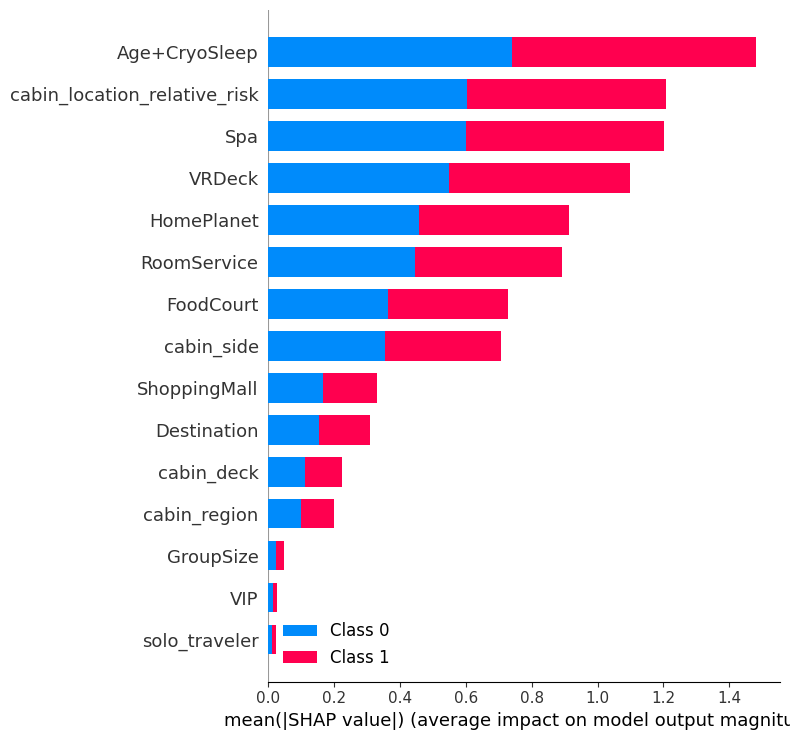

In [36]:
# Summary plot
shap.summary_plot(shap_values, X_val, feature_names=feature_names)

### 5. SHAP Summary Plot

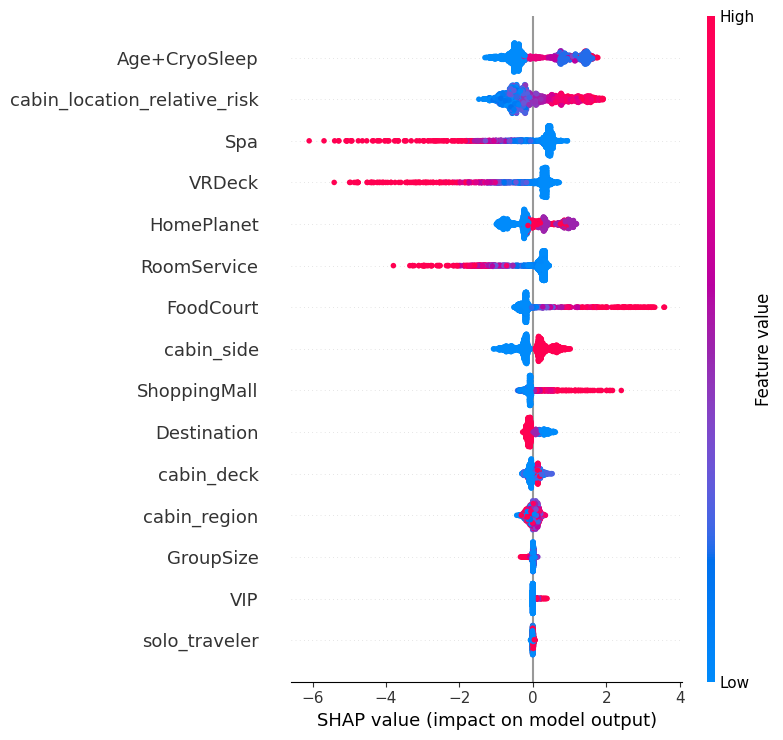

In [37]:
# Summary plot
shap.summary_plot(shap_values[1], X_val)

### 6. Dependance Plots

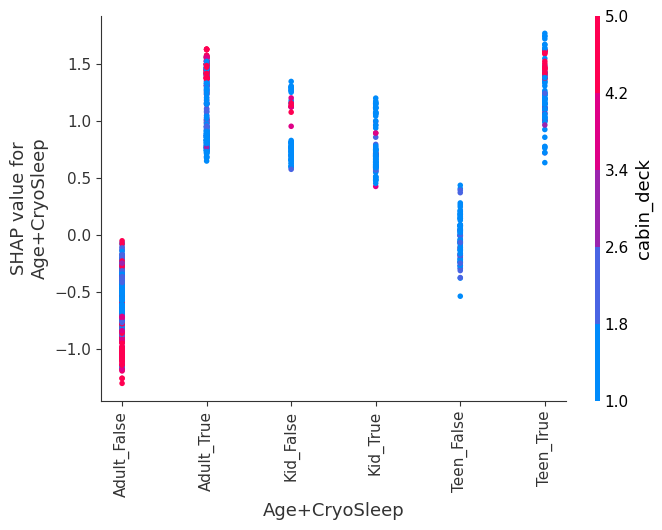

In [38]:
# Map back the original feature values for the specific feature
mapped_feature_values = X_val.copy()
feature_of_interest = 'Age+CryoSleep'

mapped_feature_values[feature_of_interest] = mapped_feature_values[feature_of_interest].apply(
    lambda x: map_back_original_value(feature_of_interest, x, label_encoders)
)

# Create the dependence plot using the mapped feature values
shap.dependence_plot(feature_of_interest, shap_values[1], mapped_feature_values)

### 7. Waterfall Plots of how the Model Scored Individual Passengers

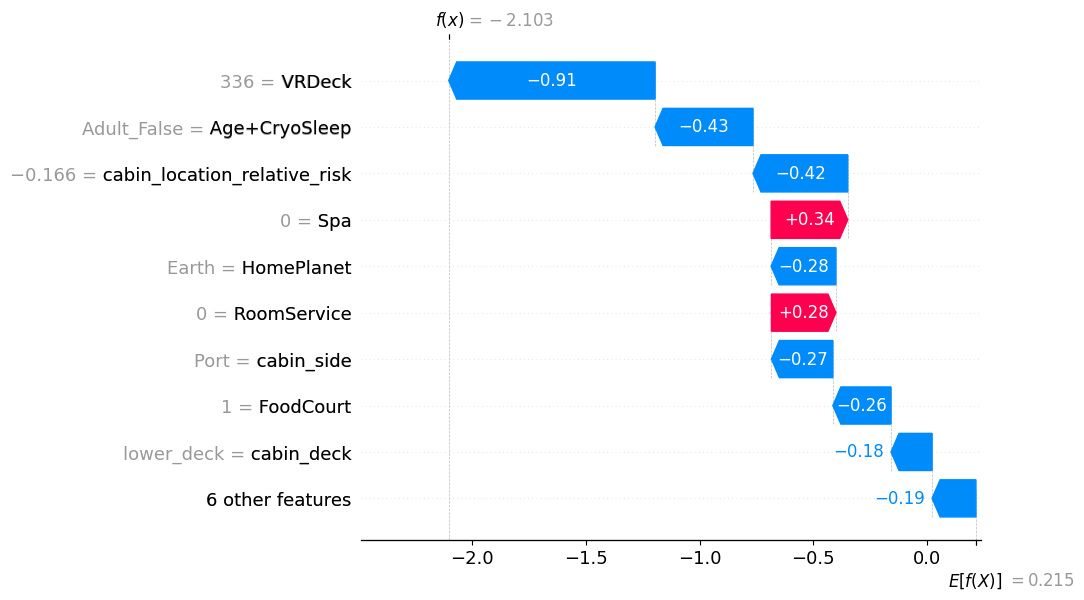

In [39]:
# Select random passenger from the validation set
random_index = np.random.randint(0, len(X_val))
random_entry = X_val.iloc[random_index]

# Map back feature values
mapped_feature_values = [map_back_original_value(col, random_entry[col], label_encoders) for col in X_val.columns]

# Create SHAP
shap_values_for_plot = shap.Explanation(
    values=shap_values[1][random_index],  # SHAP values for the selected entry
    base_values=explainer.expected_value[1],  # Expected value for the model
    data=mapped_feature_values,  # Use mapped feature values
    feature_names=X_val.columns.tolist()
)

# Create waterfall plot
shap.waterfall_plot(shap_values_for_plot)

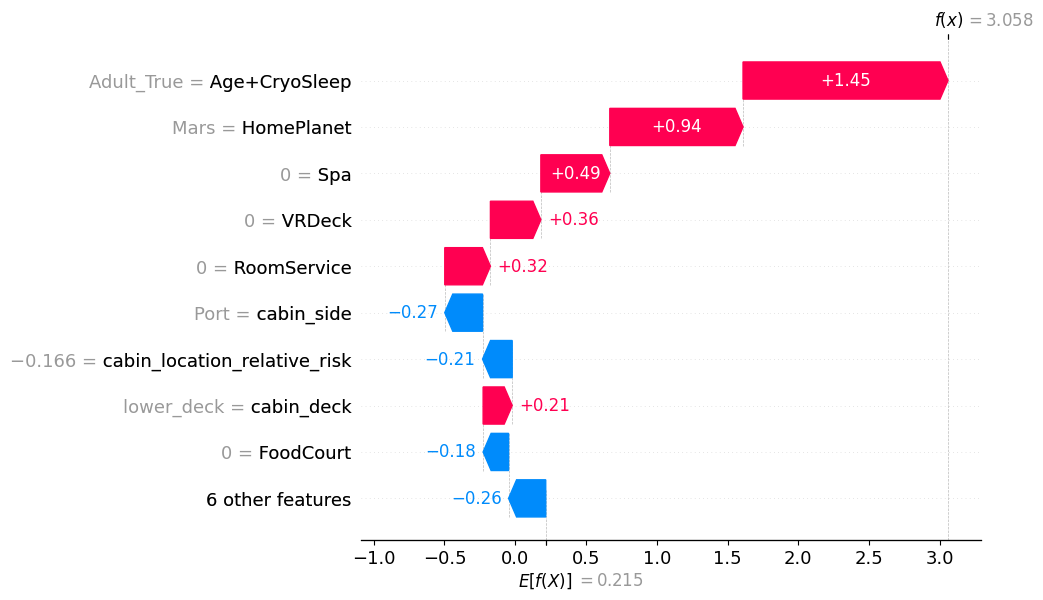

In [40]:
# Select random passenger from the validation set
random_index = np.random.randint(0, len(X_val))
random_entry = X_val.iloc[random_index]

# Map back feature values
mapped_feature_values = [map_back_original_value(col, random_entry[col], label_encoders) for col in X_val.columns]

# Create SHAP
shap_values_for_plot = shap.Explanation(
    values=shap_values[1][random_index],  # SHAP values for the selected entry
    base_values=explainer.expected_value[1],  # Expected value for the model
    data=mapped_feature_values,  # Use mapped feature values
    feature_names=X_val.columns.tolist()
)

# Create waterfall plot
shap.waterfall_plot(shap_values_for_plot)

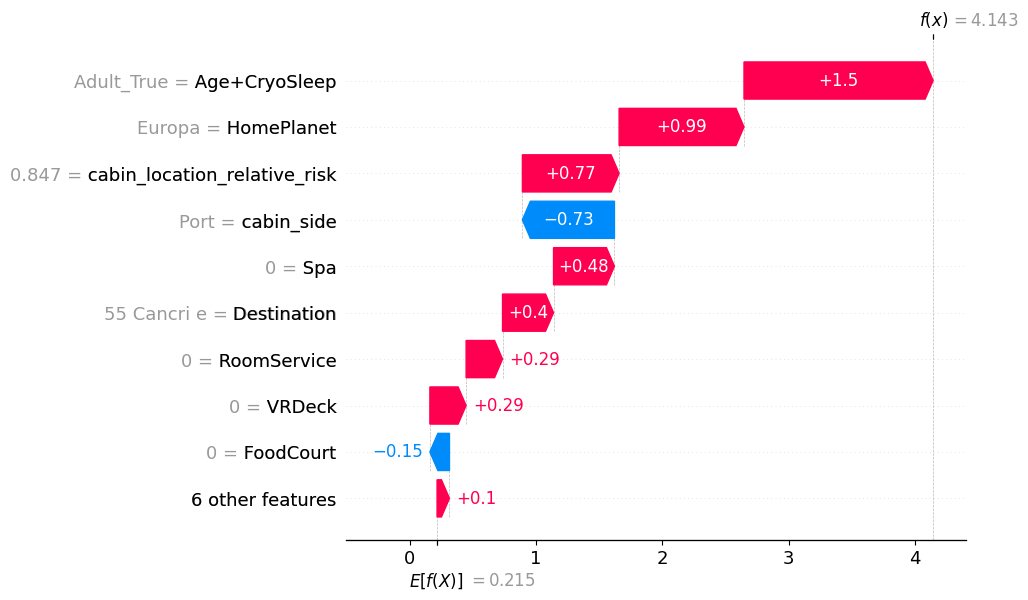

In [41]:
# Select random passenger from the validation set
random_index = np.random.randint(0, len(X_val))
random_entry = X_val.iloc[random_index]

# Map back feature values
mapped_feature_values = [map_back_original_value(col, random_entry[col], label_encoders) for col in X_val.columns]

# Create SHAP
shap_values_for_plot = shap.Explanation(
    values=shap_values[1][random_index],  # SHAP values for the selected entry
    base_values=explainer.expected_value[1],  # Expected value for the model
    data=mapped_feature_values,  # Use mapped feature values
    feature_names=X_val.columns.tolist()
)

# Create waterfall plot
shap.waterfall_plot(shap_values_for_plot)